In [ ]:
!git clone https://github.com/VikaKirichenko/wb_project.git
!pip install sentence-transformers
!pip install umap-learn
!pip install hdbscan

In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer
import matplotlib.pyplot as plt

In [93]:
df = pd.read_csv("wb_project/data/products.csv")
df = df.drop(columns=["Unnamed: 0"])
df = df.rename(columns = {"Наименование":"item_name"})
df = df[['item_name',"category"]]
df = df.drop_duplicates()

### Embeddings

1) SentenceTransformer

In [ ]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = embedding_model.encode(df['item_name'].tolist(), show_progress_bar=True)

2) BERT

In [4]:
BERT_tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased", do_lower_case=True)

def get_bert_vector(texts):
    """
    получение векторного представления с помощью предубученного BERT
    :param model:
    :return:
    """
    input_ids = []
    attention_masks = []

    for sent in texts:
        encoded_dict = BERT_tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=20,  # Pad & truncate all sentences. # увеличить для описаний
            pad_to_max_length=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt',  # Return pytorch tensors.
        )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

embeddings = get_bert_vector(df['item_name'].tolist())[0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


3) tf-idf


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_tfidf_vector(data_samples: list, ngram_range: tuple = (1, 1), n_features: int = 1000):
    """
    реализация tf-idf для построения embeddings
    :param model:
    :return:
    """
    vectorizer = TfidfVectorizer(max_features=n_features, ngram_range=ngram_range)
    x_vector = vectorizer.fit_transform(data_samples)
    return x_vector, vectorizer

embeddings = get_tfidf_vector(df['item_name'].tolist())[0]

4) word2vec

In [67]:
from gensim.models import word2vec

def document_vector(text, w2v_model):
    """
    построение вектора для документа из модели word2vec
    :param model:
    :return:
    """
    doc = [word for word in text if word in w2v_model.wv]
    return np.mean(w2v_model.wv[doc], axis=0)

def get_trained_word2vec_vector(data, workers=4, min_count=10, window=10, sample=1e-3):
    """
    получение векторного представления из модели word2vec обученной полностью на представленных данных
    :param model:
    :return:
    """
    model_en = word2vec.Word2Vec(data, workers=workers, min_count=min_count, window=window, sample=sample)
    return model_en, [document_vector(doc, model_en) for doc in data]

embeddings = get_trained_word2vec_vector(df['item_name'].tolist())[1]

In [ ]:
len(embeddings)

3153

### Umap

In [95]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

### Clustering

1) hdbscan

In [ ]:
umap_embeddings = embeddings

In [83]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,min_samples=1,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

2) k-means

elbow method

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

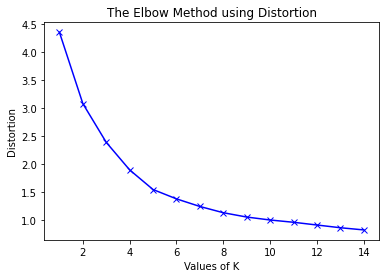

In [104]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 15)
X = umap_embeddings
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_


plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

По данному графику необходимо использовать 5 кластеров

In [105]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5)
model.fit(umap_embeddings)
yhat = model.predict(umap_embeddings)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


visualization

In [106]:
# labels = cluster.labels_
labels = yhat

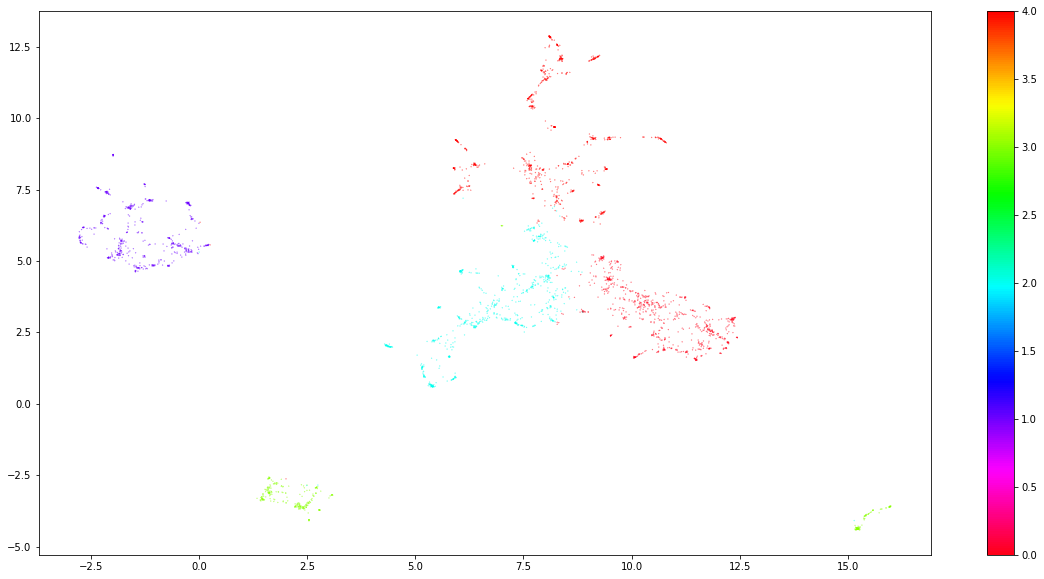

In [107]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = labels

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

Topic Creation

c-tf-idf

In [108]:
docs_df = pd.DataFrame(df['item_name'].tolist(), columns=["Doc"])
docs_df['Topic'] = labels
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [109]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(df['item_name'].tolist()))

Topic Representation

In [110]:

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 
topic_sizes.head(10)

,Topic,Size
4,4,776
0,0,755
2,2,718
1,1,551
3,3,353


In [111]:
len(topic_sizes)

5

In [116]:
df["category"].unique()

array(['Детское творчество и досуг', 'Аксессуары', 'Карповая рыбалка',
       'Ножи и аксессуары', 'Автоэлектроника и навигация'], dtype=object)

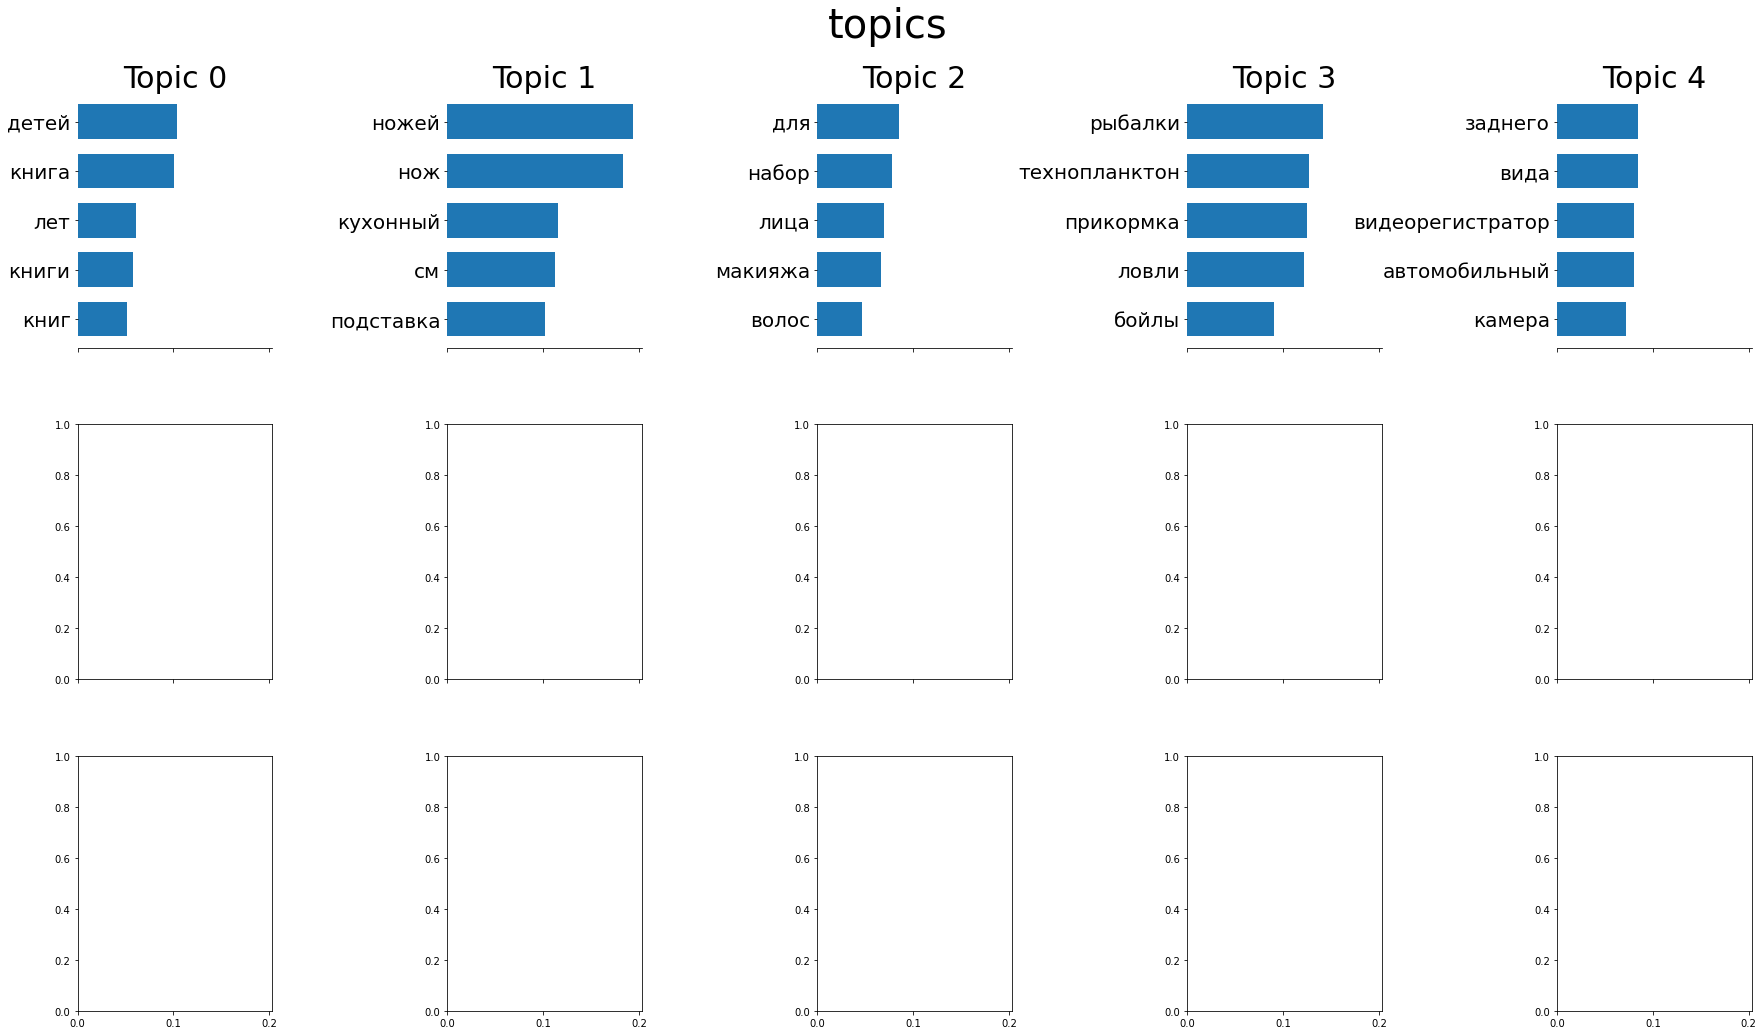

In [121]:
fig, axes = plt.subplots(3, 5, figsize=(30, 15), sharex=True)
axes = axes.flatten()
for topic in topic_sizes['Topic'].tolist():
    if topic==-1:
        continue
    weights = [i[1] for i in top_n_words[topic][:5]]
    top_features = [i[0] for i in top_n_words[topic][:5]]
    ax = axes[topic]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic}", fontdict={"fontsize": 30})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    fig.suptitle("topics", fontsize=40)

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.show()

In [ ]:
top_n_words[13][:10]

[('ножей', 0.2396302923529864),
 ('нож', 0.15688178453378948),
 ('см', 0.13061676682662132),
 ('подставка', 0.12740866757498878),
 ('кухонный', 0.10807115641700792),
 ('кухонных', 0.10537893046671923),
 ('точилка', 0.08791239864930872),
 ('для', 0.07676430355708158),
 ('набор', 0.07536757623162257),
 ('ножи', 0.06654519347180357)]

Topic Reduction

In [89]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(df['item_name'].tolist())
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); 
topic_sizes.head(10)

,Topic,Size
0,-1,733
38,37,101
31,30,100
35,34,95
40,39,86
1,0,68
45,44,62
47,46,61
51,50,59
9,8,57


In [90]:
len(topic_sizes)

52

In [ ]:
top_n_words[2][:10]

[('прикормка', 0.078107368220508),
 ('rgb', 0.0771856598348105),
 ('подсветка', 0.07264358240547861),
 ('салона', 0.06783803581397045),
 ('авто', 0.054128489087420024),
 ('лента', 0.05089396947437336),
 ('видеорегистратор', 0.05013798865171912),
 ('led', 0.048916918287554144),
 ('автомобильный', 0.04189839050969874),
 ('kumon', 0.041809465911921355)]

### BERTopic

In [ ]:
!pip install bertopic

In [14]:
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=5)

representation_model = MaximalMarginalRelevance(diversity=0.3)


def get_topics(preprocessed_data,n_topics = 15, n_gram_range = (1, 1)):
    cluster_model = KMeans(n_clusters=n_topics)
    topic_model = BERTopic(hdbscan_model=cluster_model,calculate_probabilities  = False,
                           low_memory = True,language="russian",  
                           verbose=True,n_gram_range = n_gram_range,
                           nr_topics = n_topics,representation_model=representation_model)
    topics, probs = topic_model.fit_transform(preprocessed_data) # docs - просто тексты
    return topic_model, topics, probs

def get_topics_own_embeddings(preprocessed_data, embeddings, n_topics = 10, n_gram_range = (2, 2)):
    topic_model = BERTopic(n_topics,n_gram_range,representation_model=representation_model, calculate_probabilities=True, verbose=True)
    topics, probs = topic_model.fit_transform(preprocessed_data, embeddings)
    return topic_model, topics, probs

def visualize_topics_(topic_model, type = None):
    topic_model.visualize_topics()
    topic_model.visualize_barchart()
    
def save_topics(topic_model):
    topics = topic_model.get_topic_info()['Name'].tolist()
    topics_dict = {}
    for topic in topics:
        elems = topic.split("_")
        topics_dict[elems[0]] = topic
    return topics_dict

def predict_topic(topic_model,text,n_count = 1):
    similar_topics, similarity = topic_model.find_topics(text, top_n=n_count); 
    topics_dict = save_topics(topic_model)
    return topics_dict[str(similar_topics[0])]


def predict_topics(texts,n_count):
    topics = [predict_topic(text,n_count) for text in texts]
    return topics

In [130]:
topic_model, topics, probs = get_topics(df['item_name'].tolist(),n_topics = 5)


Batches:   0%|          | 0/99 [00:00<?, ?it/s]

2023-03-25 06:27:26,600 - BERTopic - Transformed documents to Embeddings
2023-03-25 06:27:45,220 - BERTopic - Reduced dimensionality
2023-03-25 06:27:45,273 - BERTopic - Clustered reduced embeddings
2023-03-25 06:27:47,486 - BERTopic - Reduced number of topics from 5 to 5


In [126]:
len(topics)

3153

In [127]:
topics_dict = save_topics(topic_model)
topics_dict

{'0': '0_для ножей_набор ножей_кухонных ножей_кухонный нож',
 '1': '1_для детей_книги для_набор книг_детская энциклопедия',
 '2': '2_зарядное устройство_видеорегистратор автомобильный_автомобильный видеорегистратор_видеорегистратор зеркало',
 '3': '3_для рыбалки_ловли толстолобика_технопланктон для_плавающие бойлы',
 '4': '4_для макияжа_органайзер для_для волос_расческа для'}

In [134]:
topic_model.visualize_barchart(top_n_topics=5, width = 300)

In [138]:
pred = predict_topic(topic_model,"расческа брашинг")
pred

'0_лица_макияжа_волос_кисть'

### Build model on all data

In [ ]:
# !pip install sentence_transformers
!pip install umap-learn

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/group_project/filtered_data.csv",encoding = 'utf8')
df.head()

,Unnamed: 0,id,title,category,marketplace_name
0,0,2e1d9b35-895c-4aff-ace7-9a24506374eb,Рубашка офисная оверсайз Darya Selskaya,/catalog/detyam/odezhda/dlya-devochek/bluzki-i...,wildberries
1,1,0234deda-8fdf-4120-8d37-61566ed7f3d5,Рубашка оверсайз базовая Olesa Chugunova,/catalog/detyam/odezhda/dlya-devochek/bluzki-i...,wildberries
2,2,93587a0e-f74a-443f-a597-425915582f7b,Рубашка женская легкий оверсайз Life in StyIe,/catalog/detyam/odezhda/dlya-devochek/bluzki-i...,wildberries
3,3,ea1bc29d-24c7-4cc6-bc21-87c6919b628e,Блузка женская праздничная с длинным рукавом о...,/catalog/detyam/odezhda/dlya-devochek/bluzki-i...,wildberries
4,4,17e87f55-eeed-4dca-bc75-c05b6cf7aed6,Блузка офисная для девочки школьная Camicia,/catalog/detyam/odezhda/dlya-devochek/bluzki-i...,wildberries


In [4]:
len(df['category'].unique())

1065

In [9]:
from sentence_transformers import SentenceTransformer
import umap

embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = embedding_model.encode(df['title'].tolist(), show_progress_bar=True)


umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

Batches:   0%|          | 0/4581 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

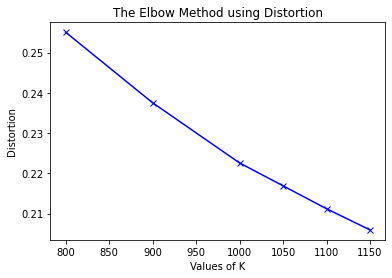

In [12]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(800, 1200)
K = [800,900,1000,1050,1100,1150]
X = umap_embeddings
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_


plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [28]:
topic_model, topics, probs = get_topics(df['title'].tolist(),n_topics = 1500)

Batches:   0%|          | 0/4581 [00:00<?, ?it/s]

2023-03-25 08:55:30,145 - BERTopic - Transformed documents to Embeddings
2023-03-25 08:58:48,539 - BERTopic - Reduced dimensionality
2023-03-25 08:58:49,367 - BERTopic - Clustered reduced embeddings
2023-03-25 08:58:51,587 - BERTopic - Reduced number of topics from 5 to 5
